In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

# z filters (grande):

object_z_filters = ['photoz_mean < 1.5', (np.isfinite, 'photoz_mean')]

truth_z_filters = ['redshift < 1.5', (np.isfinite, 'redshift')] 

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters+object_z_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters+truth_z_filters, 
                                      native_filters=healpix_filter))

In [9]:
list(truth_data)

['galaxy_id',
 'redshift',
 'halo_mass',
 'halo_id',
 'ra',
 'is_central',
 'mag_i',
 'dec']

In [10]:
truth_data['halo_mass']

array([5.07006249e+12, 5.07006249e+12, 3.79915201e+10, ...,
       1.28993621e+10, 4.89915741e+10, 2.66634575e+10])

In [11]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2038017
nombre de galaxies centrales = 1884055
pourcentage de galaxies centrales = 92.44549971859901 %
nombre d'objets = 560402


(array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
 [Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

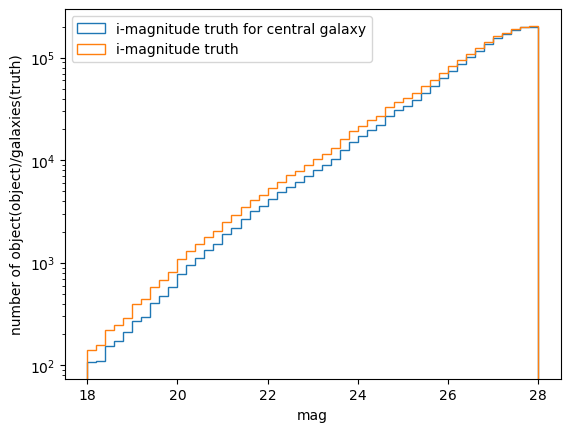

In [12]:
plt.figure()
truth_hist_central=plt.hist(truth_data['mag_i'][np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='i-magnitude truth for central galaxy', log=True)
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
        1.e+07]),
 [Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$')])

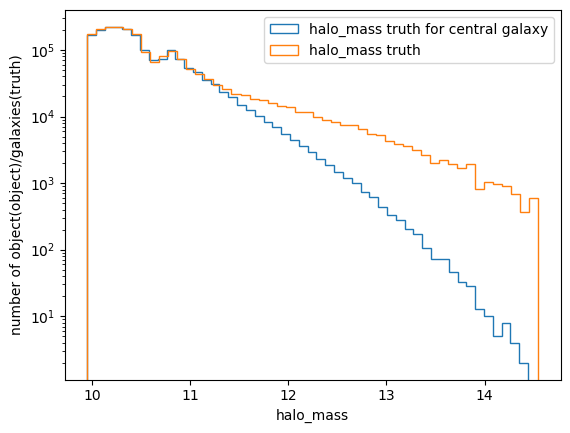

In [13]:
plt.figure()
truth_hist_central=plt.hist(np.log10(truth_data['halo_mass'])[np.where(truth_data['is_central']==True)[0]], bins=50, 
                            histtype='step', label='halo_mass truth for central galaxy', log=True)
truth_hist=plt.hist(np.log10(truth_data['halo_mass']), bins=50, histtype='step', label='halo_mass truth', log=True)
plt.legend()
plt.xlabel('halo_mass')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()

In [14]:
where_ind_central=np.where(truth_data['is_central']==True)[0]

'''redshift=truth_data['redshift']
halo_mass=truth_data['halo_mass']
mag_i=truth_data['mag_i']
galaxy_id=truth_data['galaxy_id']
is_central=truth_data['is_central']'''

"redshift=truth_data['redshift']\nhalo_mass=truth_data['halo_mass']\nmag_i=truth_data['mag_i']\ngalaxy_id=truth_data['galaxy_id']\nis_central=truth_data['is_central']"

In [15]:
list(truth_data)

['galaxy_id',
 'redshift',
 'halo_mass',
 'halo_id',
 'ra',
 'is_central',
 'mag_i',
 'dec']

### FoF algo :

In [16]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [17]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                    linking_lengths=my_linking_length)

In [18]:
results

row_index,catalog_key,group_id
int64,str6,int64
0,object,0
1887873,galaxy,0
1,object,1
488379,galaxy,1
2,object,2
485145,galaxy,2
3,object,3
640537,galaxy,3
4,object,4


In [19]:
results[results['row_index']==1] #FoF assemble les tab truth et data mais les mélanges pas

row_index,catalog_key,group_id
int64,str6,int64
1,object,1
1,galaxy,234434


In [20]:
type(results)

astropy.table.table.Table

In [21]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [22]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2073281


#### Galaxy central selection :

In [23]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results
                                                         #(relié au group_id)
type(results[truth_mask][:]['row_index'])

astropy.table.column.Column

In [24]:
ind_galax_truth = truth_data['is_central'][ind_galax]   #donne indices des galaxies dans l'ordre de results (par groupe_id)
ind_galax_truth

array([ True,  True,  True, ...,  True,  True,  True])

In [25]:
results[truth_mask][ind_galax_truth] 

row_index,catalog_key,group_id
int64,str6,int64
1887873,galaxy,0
488379,galaxy,1
485145,galaxy,2
640537,galaxy,3
665905,galaxy,4
795341,galaxy,5
642662,galaxy,6
732007,galaxy,7
1772683,galaxy,8


In [26]:
n_truth_central=np.bincount(results[truth_mask]['group_id'][ind_galax_truth], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales

print(n_truth_central)

[1 1 1 ... 1 1 1]


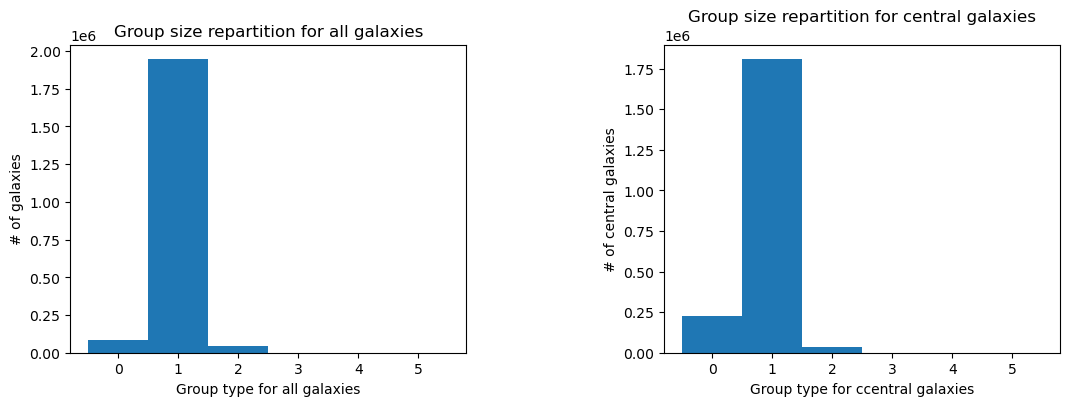

In [39]:
plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist1=plt.hist(n_truth, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5)
plt.xlabel('Group type for all galaxies')
plt.ylabel('# of galaxies')
plt.title('Group size repartition for all galaxies')

plt2=plt.subplot(122)
hist2=plt.hist(n_truth_central, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5)
plt.xlabel('Group type for ccentral galaxies')
plt.ylabel('# of central galaxies')
plt.title('Group size repartition for central galaxies')

plt.show()

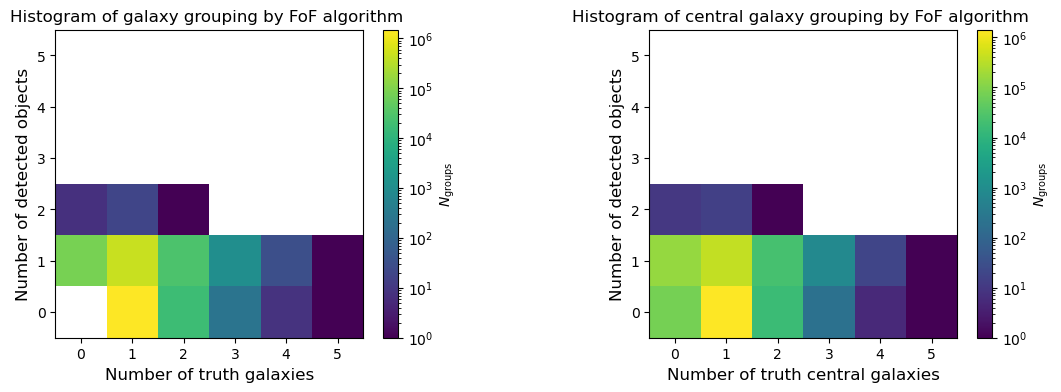

In [37]:
#average number of galaxies by groupsplt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm());

plt.figure(figsize=(11,4))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxy grouping by FoF algorithm ')

plt2=plt.subplot(122)
hist2d2=plt.hist2d(n_truth_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5,
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxy grouping by FoF algorithm ')

plt.show()

#attention histo en échelles log

In [98]:
print(hist2d1[0][:,0])
print(hist2d2[0][:,0])

[0.000000e+00 1.495248e+06 1.740900e+04 2.400000e+02 8.000000e+00
 1.000000e+00]
[7.413300e+04 1.422947e+06 1.562100e+04 1.990000e+02 5.000000e+00
 1.000000e+00]


In [102]:
#on ne prend pas en compte les erreurs de mesures (1ère colonne)

print(hist2d2[0][2,1]) #nbr 2-1 system, unrecognized blend
print(hist2d2[0][:,1:])

21464.0
[[1.54203e+05 1.00000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [3.83885e+05 1.50000e+01 0.00000e+00 0.00000e+00 0.00000e+00]
 [2.14640e+04 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [7.79000e+02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.80000e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]]


In [105]:
print("% of unrecognized blended groups for all galaxies (only for system n-1) =", (hist2d1[0][2,1]/np.sum(hist2d1[0][:,1:]))*100) 

% of unrecognized blended groups for all galaxies (only for system n-1) = 4.876190272245777


In [106]:
print("% of unrecognized blended groups for central galaxies (only for system n-1) =", (hist2d2[0][2,1]/np.sum(hist2d2[0][:,1:]))*100 )

% of unrecognized blended groups for central galaxies (only for system n-1) = 3.830285379816409


Remarque :

* Apparation en grande quantité de systèmes (0-0) quand on retire les galaxies satellites.

* Augmentation légère de système (0-1) (ie, erreur de mesure) pour les galaxies centrales.

Conclusion : Galaxies sans objets attachés sont généralement pas centrale.
Galaxies satellites sont généralement des galaxies isolées. Pas très précis => faire 1ere coupure avec halo masse pour se mettre dans régime des amas. 

## Halo Mass Cut :

In [48]:
halo_mass_cut=10**12.5

In [54]:
len(results[truth_mask][ind_galax_truth])

1884055

In [62]:
len(np.where(truth_data['halo_mass']>halo_mass_cut)[0])

66649

In [52]:
#selection galaxies centrales (=halo) de masse >10**12.5 parmis toutes les galaxies 

central_galax=results[truth_mask][ind_galax_truth][np.where(truth_data['halo_mass']>halo_mass_cut)[0]]

IndexError: index 1884058 is out of bounds for axis 0 with size 1884055

### DC2 Haloes, DC2 Objects :

In [ ]:
halos_data = cosmodc2.get_quantities(['ra','dec','redshift','galaxy_id','is_central','halo_id','halo_mass'],   # central_galax=halo
                                            filters=pos_filters+['is_central'],native_filters=healpix_filter)

print(len(np.where(truth_data['is_central']==True)[0]))
print(len(truth_data['is_central']))

In [ ]:
print("nombre de halo=", len(halos_data['ra']))

In [ ]:
results_halo = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                      'halos':pd.DataFrame(halos_data)},
                                                      linking_lengths=my_linking_length)

In [ ]:
results_halo

In [ ]:
object_mask_halo=

n_groups_halo=results_halo['group_id'].max()+1
n_object=np.bincount(results_halo['group_id'][object_mask_halo], minlength=n_groups))

In [ ]:
hist2=plt.hist2d(n_truth_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth_central))+2)-0.5, 
                    norm=mpl.colors.LogNorm())
plt.xlabel('Number of truth central galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of central galaxy grouping by FoF algorithm ')